<a href="https://colab.research.google.com/github/ptah0414/stock-coin-price-prediction/blob/main/06_18_ethereum_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries anomaly detection using an Autoencoder



## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data


In [ ]:
# !pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 8.4 MB/s 


In [ ]:
import pyupbit

In [ ]:
# day/minute1/minute3/minute5/minute10/minute15/minute30/minute60/minute240/week/month
interval_upbit = "minute5"

unit = 288 # 하루에 몇 개
train_period = 160
test_period = 40

In [ ]:
ticker = "KRW-ETH"
df = pyupbit.get_ohlcv(ticker, interval=interval_upbit, count=unit*(train_period+test_period))

In [ ]:
df_plot = df[-unit*test_period:]
# df_plot["close"].plot()

In [ ]:
df["close_chg"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1) * 100
df = df.fillna(method = "bfill")
df = df[["close_chg"]]
df

,close_chg
2021-11-30 03:30:00,0.090449
2021-11-30 03:35:00,0.090449
2021-11-30 03:40:00,-0.072294
2021-11-30 03:45:00,-0.036173
2021-11-30 03:50:00,-0.090465
...,...
2022-06-18 10:45:00,0.317237
2022-06-18 10:50:00,0.140548
2022-06-18 10:55:00,-0.245614
2022-06-18 11:00:00,-0.246219


In [ ]:
df_small_noise = df[:unit*train_period]
df_daily_jumpsup = df[-unit*test_period:]

In [ ]:
df_small_noise

,close_chg
2021-11-30 03:30:00,0.090449
2021-11-30 03:35:00,0.090449
2021-11-30 03:40:00,-0.072294
2021-11-30 03:45:00,-0.036173
2021-11-30 03:50:00,-0.090465
...,...
2022-05-09 08:55:00,0.302939
2022-05-09 09:00:00,0.000000
2022-05-09 09:05:00,0.090607
2022-05-09 09:10:00,-0.030175


In [ ]:
df_daily_jumpsup

,close_chg
2022-05-09 09:20:00,0.302480
2022-05-09 09:25:00,0.180941
2022-05-09 09:30:00,-0.030102
2022-05-09 09:35:00,0.120446
2022-05-09 09:40:00,0.060150
...,...
2022-06-18 10:45:00,0.317237
2022-06-18 10:50:00,0.140548
2022-06-18 10:55:00,-0.245614
2022-06-18 11:00:00,-0.246219


## Quick look at the data

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

In [ ]:
# # 정상 데이터
# fig, ax = plt.subplots()
# df_small_noise.plot(legend=False, ax=ax)
# plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

In [ ]:
# # 테스트 데이터
# fig, ax = plt.subplots()
# df_daily_jumpsup.plot(legend=False, ax=ax)
# plt.show()

##정상 데이터(주황) & 테스트 데이터(파랑)

In [ ]:
# fig, ax = plt.subplots()
# df_daily_jumpsup.plot(legend=False, ax=ax)
# df_small_noise.plot(legend=False, ax=ax)
# plt.ylim([-50, 50])
# plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [ ]:
# df_small_noise = df

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 46080


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [ ]:
TIME_STEPS = unit

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (45793, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
322/322 [==============================] - 39s 116ms/step - loss: 0.2211 - val_loss: 0.0133
Epoch 2/50
322/322 [==============================] - 27s 83ms/step - loss: 0.1006 - val_loss: 0.0155
Epoch 3/50
322/322 [==============================] - 27s 83ms/step - loss: 0.0747 - val_loss: 0.0241
Epoch 4/50
322/322 [==============================] - 27s 84ms/step - loss: 0.0570 - val_loss: 0.0305
Epoch 5/50
322/322 [==============================] - 27s 84ms/step - loss: 0.0497 - val_loss: 0.0292
Epoch 6/50
322/322 [==============================] - 27s 84ms/step - loss: 0.0457 - val_loss: 0.0295


Let's plot training and validation loss to see how the training went.

In [ ]:
# plt.plot(history.history["loss"], label="Training Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()
# plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


#Threshold 설정

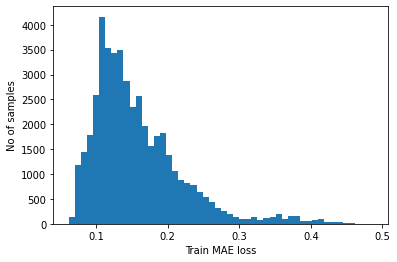

Reconstruction error threshold:  0.4871010974071195


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [ ]:
# threshold = np.max(train_mae_loss) 
# threshold

In [ ]:
print(np.mean(train_mae_loss) + 6 * np.std(train_mae_loss))
print(np.max(train_mae_loss))

0.5363866499085039
0.4871010974071195


In [ ]:
threshold = np.mean(train_mae_loss) + 6 * np.std(train_mae_loss)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

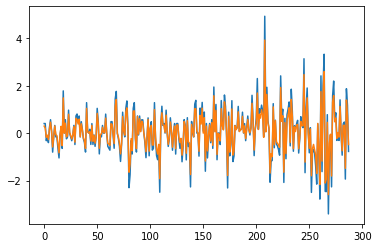

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [ ]:
len(x_train)

45793

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

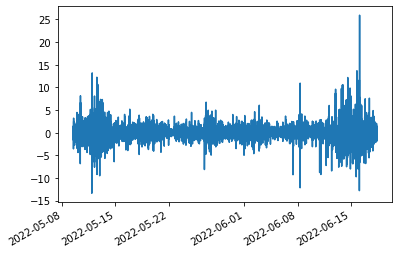

Test input shape:  (11233, 288, 1)


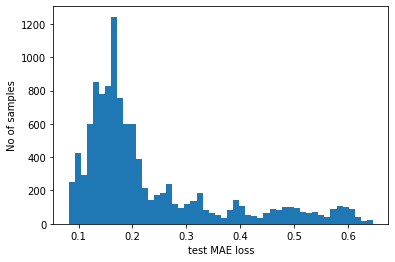

Number of anomaly samples:  617
Indices of anomaly samples:  (array([  630,   631,   633,   634,   635,   636,   637,   638,   639,
         640,   641,   642,   643,   644,   645,   646,   647,   648,
         649,   650,   651,   652,   653,   654,   655,   656,   657,
         658,   659,   660,   661,   662,   663,   664,   665,   666,
         667,   668,   669,   670,   671,   672,   673,   674,   675,
         676,   677,   678,   679,   680,   681,   682,   683,   684,
         685,   686,   687,   688,   689,   690,   691,   692,   693,
         694,   695,   696,   697,   698,   699,   700,   701,   702,
         703,   704,   705,   706,   707,   708,   709,   710,   711,
         712,   713,   714,   715,   716,   717,   718,   719,   720,
         721,   722,   723,   724,   725,   726,   727,   728,   729,
         730,   731,   732,   733,   734,   735,   736,   737,   738,
         739,   740,   741,   742,   743,   744,   745,   746,   747,
         748,   749,   750, 

In [ ]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
# plt.ylim([-50, 50])
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
TIME_STEPS = 72 # 4시간 이상 threshold를 넘길 때 anormaly detect
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(anomalies) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
# anomalous_data_indices

In [ ]:
len(anomalous_data_indices)

372

Let's overlay the anomalies on the original test data plot.

anormaly detected!


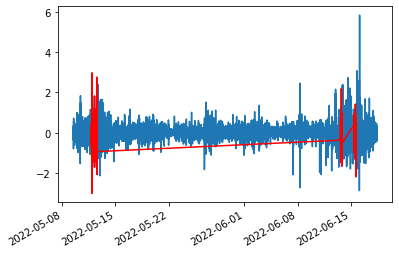

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
if anomalous_data_indices:
  df_subset.plot(legend=False, ax=ax, color="r")
  print("anormaly detected!")
# plt.ylim([-50, 50])
plt.show()

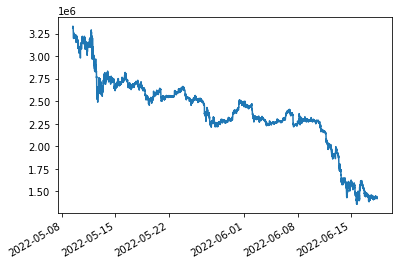

In [ ]:
df_plot["close"].plot()

anormaly detected!


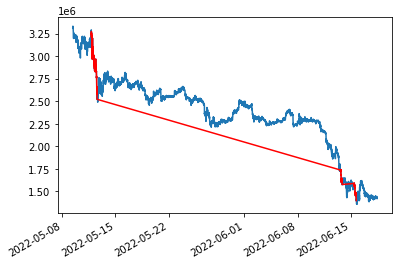

In [ ]:
df_subset = df_plot["close"].iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_plot["close"].plot(legend=False, ax=ax)
if anomalous_data_indices:
  df_subset.plot(legend=False, ax=ax, color="r")
  print("anormaly detected!")
plt.show()

In [ ]:
len(anomalous_data_indices)

372

In [ ]:
df_daily_jumpsup.iloc[anomalous_data_indices]

,close_chg
2022-05-11 20:00:00,-0.643580
2022-05-11 20:05:00,0.431832
2022-05-11 20:10:00,0.491400
2022-05-11 20:15:00,-0.152812
2022-05-11 20:20:00,-0.428528
...,...
2022-06-15 16:50:00,0.034941
2022-06-15 16:55:00,0.349284
2022-06-15 17:00:00,-2.192830
2022-06-15 17:05:00,0.142349
